In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import lasagne as L

from IPython import display

from util import *
from rosenbrock import RosenbrockFunction_Tensor

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
%run ../lstm_optimizer_params.py
%run ../ntm_bfgs_optimizer_params.py
%run ../chain_optimizer.py

In [3]:
#A = T.scalar()
#B = T.scalar()
A = T.vector('A')
B = T.vector('B')

func = lambda theta, A, B: RosenbrockFunction_Tensor(theta, A, B).func

In [4]:
options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,
    'gradient_clipping': 1,
    'loglr': True,
}

In [5]:
def sample_point(ndim=2, *args):
    return np.zeros(2)

def sample_point_second_phase(ndim=2, a=None, b=None):
    return np.array([a, a**2]) + 0.01 * np.random.uniform(low=-1, high=1, size=2)

def sample_params(ndim=None, *args):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None, sample_point=sample_point):#_second_phase):
    a, b = sample_params(ndim)
    theta = sample_point(ndim, a, b)
    
    return theta, (a, b)

def grid_sampler(low, high, num=100):
    d = (high - low) / num
    x = np.linspace(low, high, num)
    y = np.linspace(low, high, num)
    xv, yv = np.meshgrid(x, y)
    return [(np.array([xv[i, j], yv[i, j]]), sample_params()) for i in range(num) for j in range(num)]

def grid_sampler_2(n_functions, dx, dy, num=100):
    problems = []
    for _ in range(n_functions):
        a, b = sample_params()
        x = np.linspace(a - dx, a + dx, num)
        y = np.linspace(a**2 - dy, a**2 + dy, num)
        xv, yv = np.meshgrid(x, y)
        problems += [(np.array([xv[i, j], yv[i, j]]), a, b) for i in range(num) for j in range(num)]
    return list(map(np.array, zip(*problems)))

def multisampler(n, *args):
    A = np.random.uniform(low=-3, high=3, size=n)
    B = np.random.uniform(20, 100, size=n)
    theta = np.zeros((n, 2))
    return theta, A, B

In [6]:
#train_inputs = grid_sampler(-3, 3, 100) + grid_sampler(-0.3, 0.3, 100) + grid_sampler(-0.03, 0.03, 100) + grid_sampler(-0.003, 0.003, 100)
#train_inputs = (np.array([p[0] for p in train_inputs]), np.array([p[1][0] for p in train_inputs]), np.array([p[1][1] for p in train_inputs]))

_thetas = []
_as = []
_bs = []

for d in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    _theta, _a, _b = grid_sampler_2(100, d, d, 20)
    
    _thetas.append(_theta)
    _as.append(_a)
    _bs.append(_b)

#_theta, _a, _b = grid_sampler_2(100, 1, 1, 20)
#_theta2, _a2, _b2 = grid_sampler_2(100, 0.1, 0.1, 20)
#_theta3, _a3, _b3 = grid_sampler_2(100, 0.01, 0.01, 20)
#train_inputs = np.concatenate([_theta, _theta2, _theta3]), np.concatenate([_a, _a2, _a3]), np.concatenate([_b, _b2, _b3])
train_inputs = np.concatenate(_thetas), np.concatenate(_as), np.concatenate(_bs)

Time compiling value_fn: 0.22605109214782715


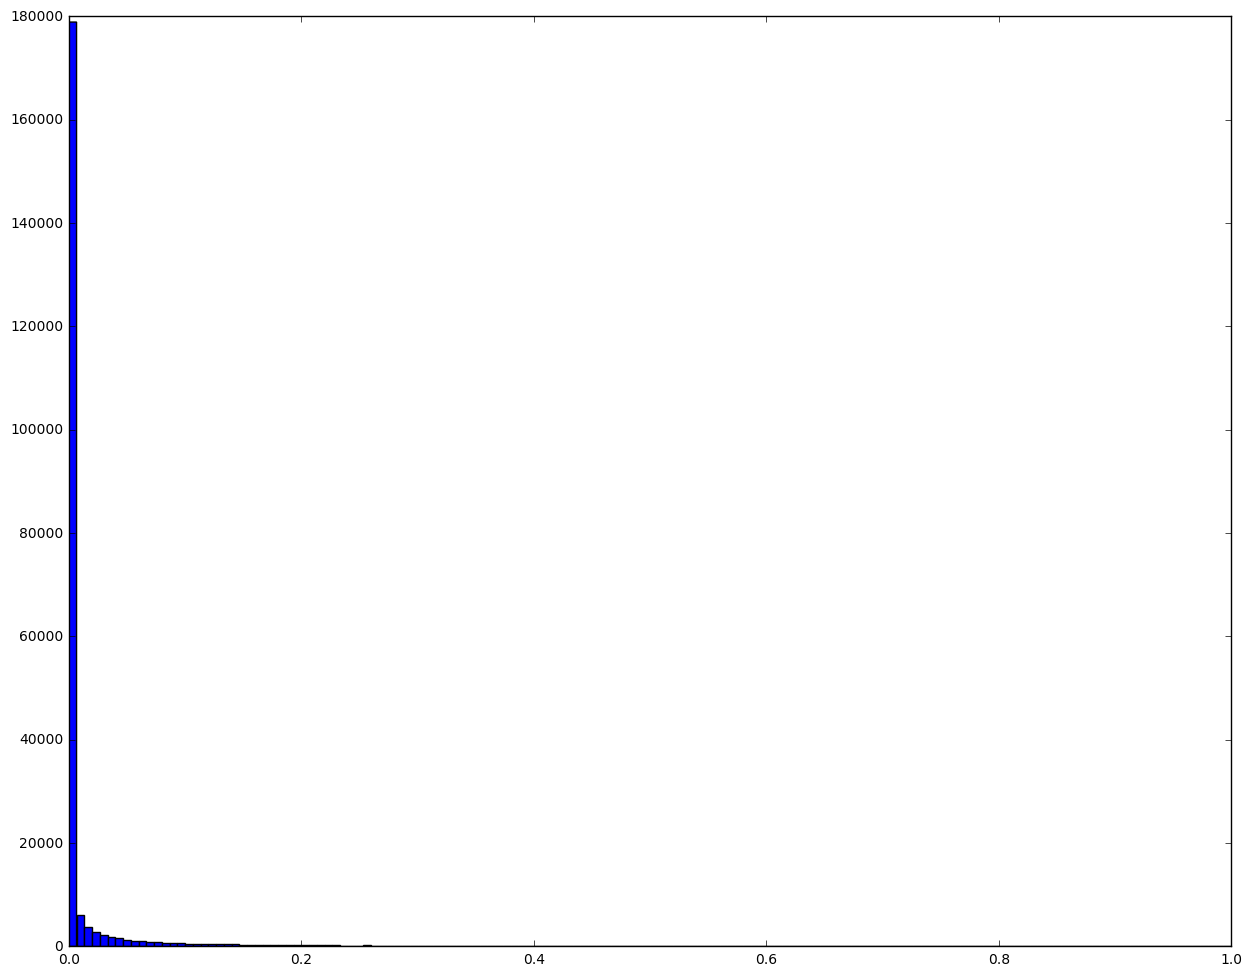

In [7]:
opt = NTM_BFGS_Optimizer(params_input=[A, B], **options)
opt.prepare_value_fn()

values = opt.value_fn(*train_inputs)
plt.figure(figsize=(15, 12))
plt.hist(values[values < 1], bins=150);

In [8]:
partition = get_partition(train_inputs, values, [1e2, 1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
len(partition)

8

In [28]:
new_partition = []

for p in partition:
    print(len(p[0]))
    indices = np.arange(len(p[0]))
    np.random.shuffle(indices)
    
    new_partition.append((p[0][indices][:12000], p[1][indices][:12000], p[2][indices][:12000]))

19791
38449
39415
40798
38397
41672
39092
22378


In [29]:
options['n_gac'] = 0
n_opt = len(partition)
opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[A, B], **options) for i in range(n_opt)]
chain_optimizer = ChainOptimizer(opts, n_small_steps=20)

In [30]:
chain_optimizer.prepare(loss_type='sum', start_lr=0.001)

Time compiling value_fn: 0.09375977516174316
Time compiling loss_fn: 2.554462432861328
Time compiling train_fn: 79.21407318115234
Time compiling value_fn: 0.13394474983215332
Time compiling loss_fn: 2.3942222595214844
Time compiling train_fn: 69.47929000854492
Time compiling value_fn: 0.09366726875305176
Time compiling loss_fn: 2.4241740703582764
Time compiling train_fn: 77.00778555870056
Time compiling value_fn: 0.09504127502441406
Time compiling loss_fn: 2.2415924072265625
Time compiling train_fn: 85.8711633682251
Time compiling value_fn: 0.0905921459197998
Time compiling loss_fn: 2.3530657291412354
Time compiling train_fn: 72.5707197189331
Time compiling value_fn: 0.09156680107116699
Time compiling loss_fn: 2.4457552433013916
Time compiling train_fn: 87.41922521591187
Time compiling value_fn: 0.09502553939819336
Time compiling loss_fn: 2.2944395542144775
Time compiling train_fn: 73.72577929496765
Time compiling value_fn: 0.09158754348754883
Time compiling loss_fn: 2.4016711711883545

In [31]:
# train_inputs = multisampler(8000)
val_inputs = multisampler(8000)

In [32]:
n_epochs   = 30
batch_size = 400

training_options = {
    'n_epochs'  : n_epochs,
    'batch_size': batch_size,
    'decay_rate': 1.0,
    'verbose': True
}

iterations = [20]
n_functions = n_epochs * batch_size

In [33]:
losses = []
for j in range(n_opt):
    chain_optimizer.opts[j].lr.set_value(0.005)
    chain_optimizer.opts[j].reset_network()
    
    training_options['n_iter'] = 20
    opt_loss, val_loss = chain_optimizer.opts[j].train(new_partition[j], val_inputs, **training_options)
    losses.append((opt_loss, val_loss))

Epoch number 0
	Time: 3.9876351356506348
	Optimizer loss: 1747.0676328125007
	Median final loss: 0.31860628724098206
	Validation loss: 42.64873779296875
Epoch number 1
	Time: 4.054734945297241
	Optimizer loss: 1134.6726484375
	Median final loss: 0.35633397102355957
	Validation loss: 34.48343591308594
Epoch number 2
	Time: 3.8277862071990967
	Optimizer loss: 990.2402812500001
	Median final loss: 0.02605079673230648
	Validation loss: 41.624721435546874
Epoch number 3
	Time: 4.076823711395264
	Optimizer loss: 856.7472838541668
	Median final loss: 0.015721678733825684
	Validation loss: 40.15154699707032
Epoch number 4
	Time: 3.986924409866333
	Optimizer loss: 771.9305885416668
	Median final loss: 0.013002537190914154
	Validation loss: 35.40611267089844
Epoch number 5
	Time: 3.801969289779663
	Optimizer loss: 750.2246236979166
	Median final loss: 0.01350274309515953
	Validation loss: 33.65921435546874
Epoch number 6
	Time: 3.918551445007324
	Optimizer loss: 785.9704114583333
	Median final l

In [47]:
# # del losses[-2:]
# for j in range(n_opt-3, n_opt-1):
#     chain_optimizer.opts[j].lr.set_value(0.001)
#     chain_optimizer.opts[j].reset_network()
    
#     training_options['n_iter'] = 20
#     opt_loss, val_loss = chain_optimizer.opts[j].train(new_partition[j], val_inputs, **training_options)
#     losses[j] = (opt_loss, val_loss)

Epoch number 0
	Time: 3.595519781112671
	Optimizer loss: 0.0894678912454595
	Median final loss: 0.0008431660244241357
	Validation loss: 58.315216308593754
Epoch number 1
	Time: 3.7488322257995605
	Optimizer loss: 0.011937458475430807
	Median final loss: 0.000260926375631243
	Validation loss: 58.91841137695313
Epoch number 2
	Time: 3.8674590587615967
	Optimizer loss: 0.008499638295421998
	Median final loss: 0.00022882506891619414
	Validation loss: 59.295246093749995
Epoch number 3
	Time: 3.7813398838043213
	Optimizer loss: 0.001120391139139732
	Median final loss: 1.716169572318904e-05
	Validation loss: 59.40917602539063
Epoch number 4
	Time: 3.7036006450653076
	Optimizer loss: 0.0007038365205128988
	Median final loss: 2.04152638616506e-05
	Validation loss: 59.50526953124999
Epoch number 5
	Time: 3.688413619995117
	Optimizer loss: 0.0008252234955628714
	Median final loss: 4.628272290574387e-05
	Validation loss: 59.62655737304688
Epoch number 6
	Time: 3.5783915519714355
	Optimizer loss: 0

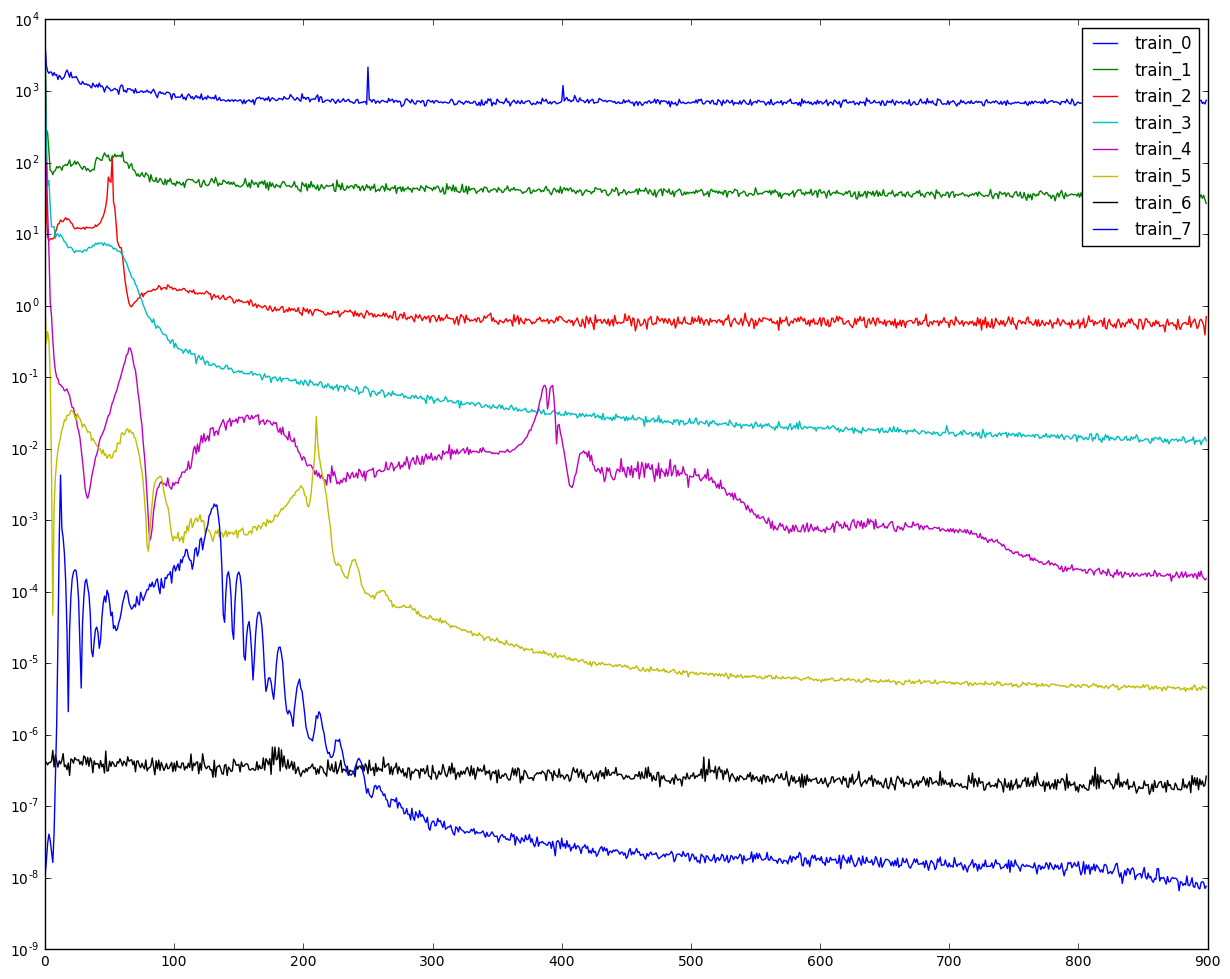

In [48]:
plt.figure(figsize=(15, 12))
for k, (train_loss, val_loss) in enumerate(losses):
    plt.semilogy(train_loss, label='train_{}'.format(k))
#     plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(k))
plt.legend();

In [18]:
chain_optimizer_loss = []
for n_iter in iterations:
    training_options['n_iter'] = n_iter
    #chain_optimizer_loss += chain_optimizer.train_on_grid(problems_grid, [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4], **training_options)
    #chain_optimizer_loss += chain_optimizer.train_on_grid(problems_grid, [1e2, 1e1, 1e0, 1e-1, 1e-2], **training_options)
    
#     opt_loss, val_loss = chain_optimizer.train(sample_point_and_params, X_val=problems_grid, **training_options)
    opt_loss = chain_optimizer.train_on_grid(train_inputs, [1e2, 1e0, 1e-2], **training_options)
#     opt_loss, val_loss = chain_optimizer.opts[0].train(train_inputs, val_inputs, **training_options)
#     opt_loss, val_loss = chain_optimizer.train(train_inputs, val_inputs, **training_options)
#     opt_loss, val_loss = chain_optimizer.opts[0].train_sampler(multisampler, val_inputs, **training_options)
    chain_optimizer_loss += opt_loss

Training optimizer number 0
Epoch number 0
	Time: 11.370084762573242
	Optimizer loss: 14448.466755555555
	Median final loss: 5.622286796569824
Epoch number 1
	Time: 16.835174560546875
	Optimizer loss: 2927.4984222222224
	Median final loss: 2.456448554992676
Epoch number 2
	Time: 18.484009265899658
	Optimizer loss: 2870.4348000000005
	Median final loss: 1.9788403511047363
Epoch number 3
	Time: 12.097574949264526
	Optimizer loss: 2583.1940111111107
	Median final loss: 1.9968132972717285
Epoch number 4
	Time: 11.338821411132812
	Optimizer loss: 2292.3794444444443
	Median final loss: 1.84175443649292
Epoch number 5
	Time: 11.230586051940918
	Optimizer loss: 2138.851866666667
	Median final loss: 1.8508715629577637
Epoch number 6
	Time: 11.353909015655518
	Optimizer loss: 2040.184488888889
	Median final loss: 1.7814691066741943
Epoch number 7
	Time: 11.264944076538086
	Optimizer loss: 2006.2611888888891
	Median final loss: 1.7791166305541992
Epoch number 8
	Time: 11.330272912979126
	Optimize

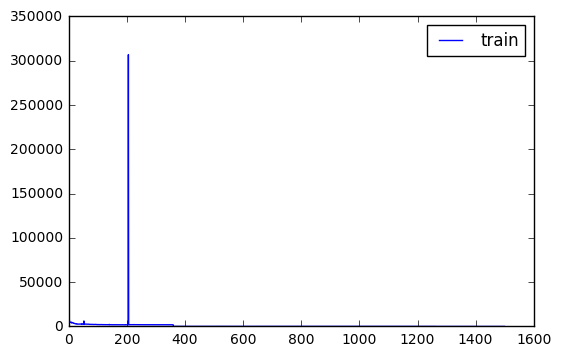

In [19]:
plt.plot(chain_optimizer_loss, label='train')
k = len(train_inputs[0]) // batch_size
# plt.semilogy(np.arange(len(val_loss)) * k, val_loss, label='val')
# plt.semilogy(np.arange(len(val_loss)), val_loss, label='val')
plt.legend();

In [16]:
from rosenbrock import RosenbrockFunction

AA = T.scalar('a')
BB = T.scalar('b')
func_ = lambda theta: RosenbrockFunction(theta, AA, BB).func

sgd_fn = make_sgd(func_, var=[AA, BB])
momentum_fn = make_momentum(func_, var=[AA, BB])
lbfgs_fn = make_lbfgs(func_, m=10, init_lr=2e-4, var=[AA, BB])

non_lstm_optimizers = {
    'sgd': sgd_fn,
    'momentum': momentum_fn, 
    'lbfgs': lbfgs_fn
}

In [17]:
lstm_optimizers = {'chain': chain_optimizer}

In [18]:
from collections import namedtuple
TestCase = namedtuple('TestCase', 'n_iter n_functions')

In [49]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results.append(histories)

Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs


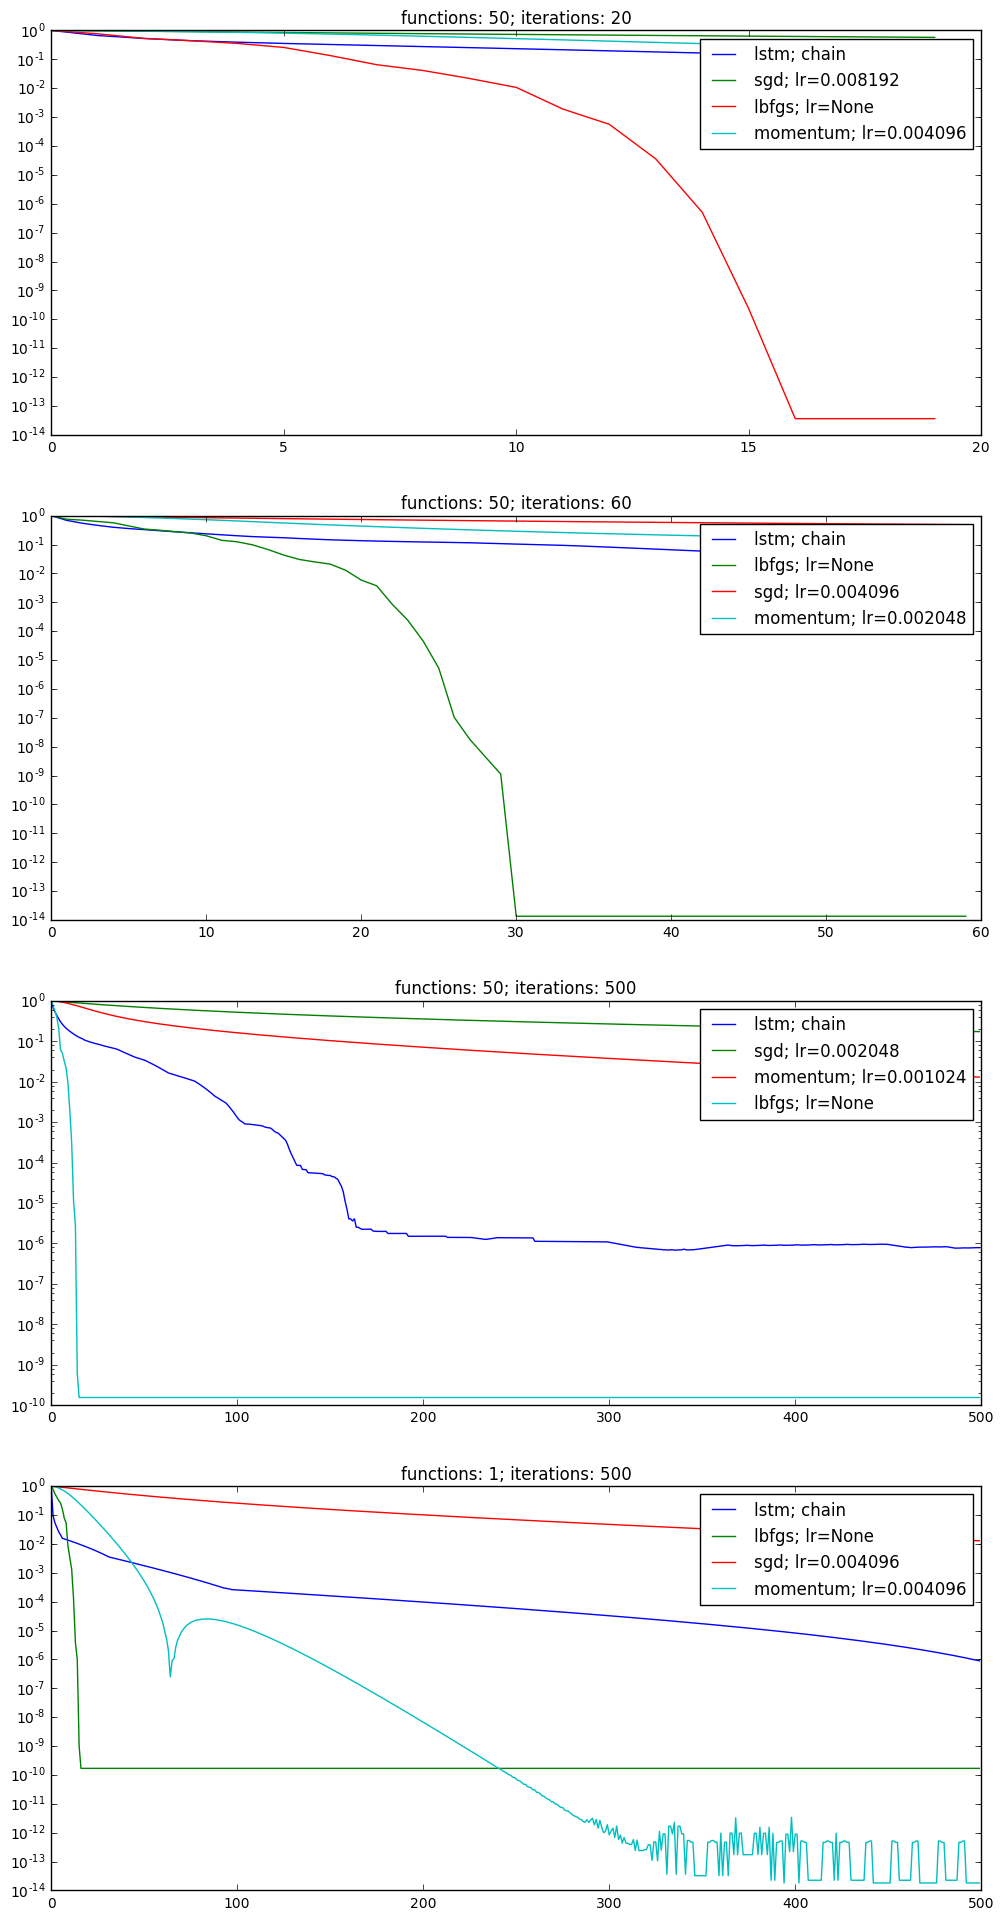

In [50]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results), figsize=(12, 6 * len(tests_results)))

if len(tests_results) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

(0.2778979651278073, 0.07722727902217599)


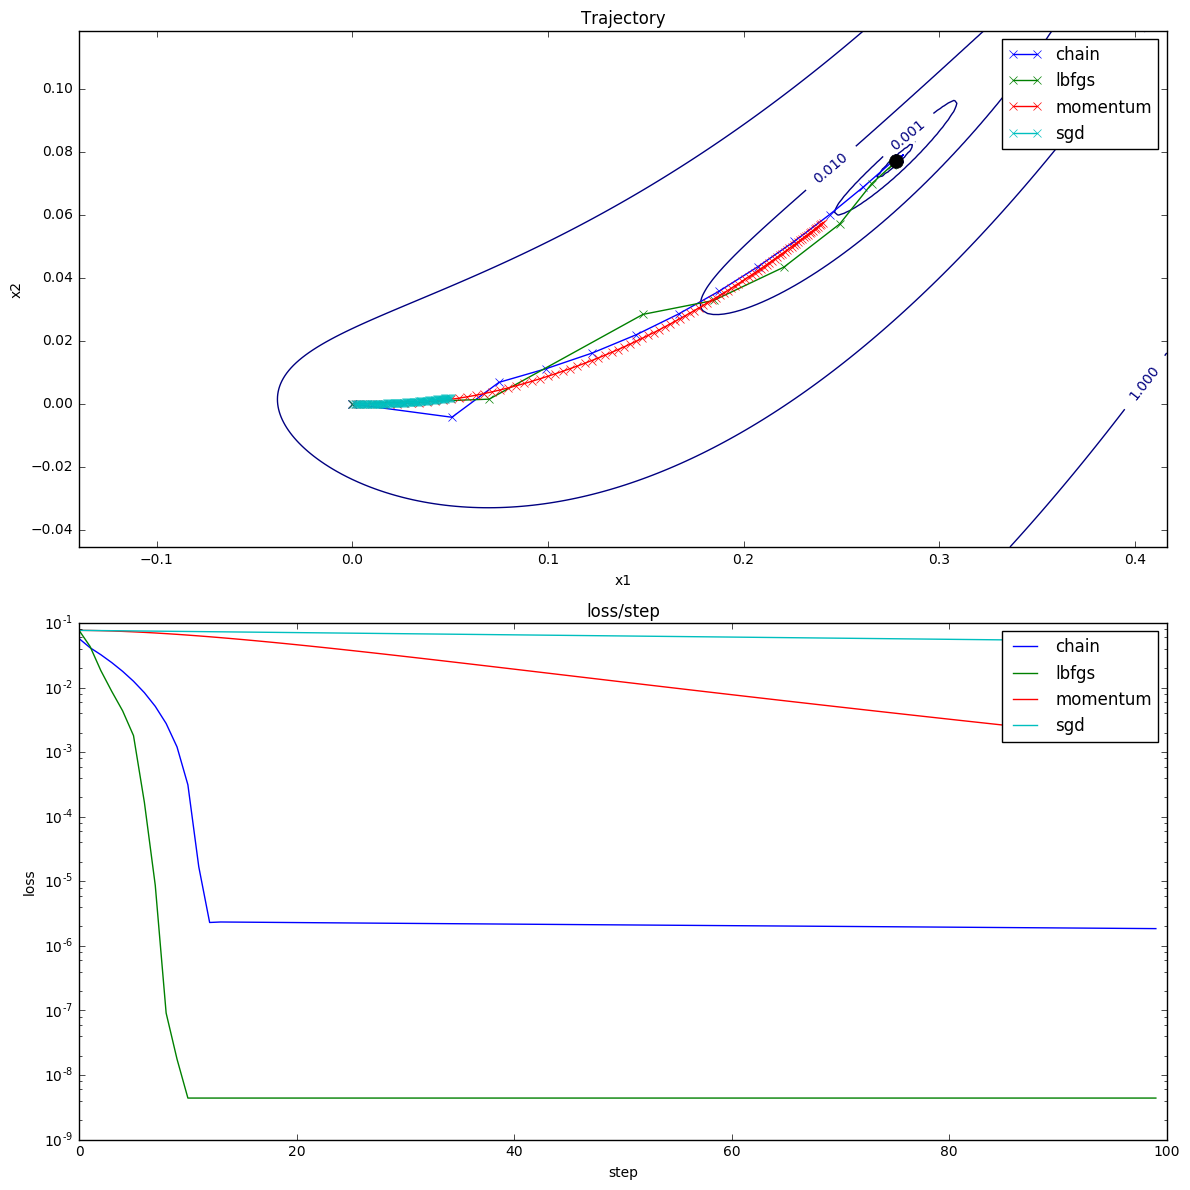

In [37]:
%matplotlib inline
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, non_lstm_optimizers)
# draw_trajectory(100, problem, lstm_optimizers, non_lstm_optimizers)

(2.9721520343470234, 8.83368771527315)


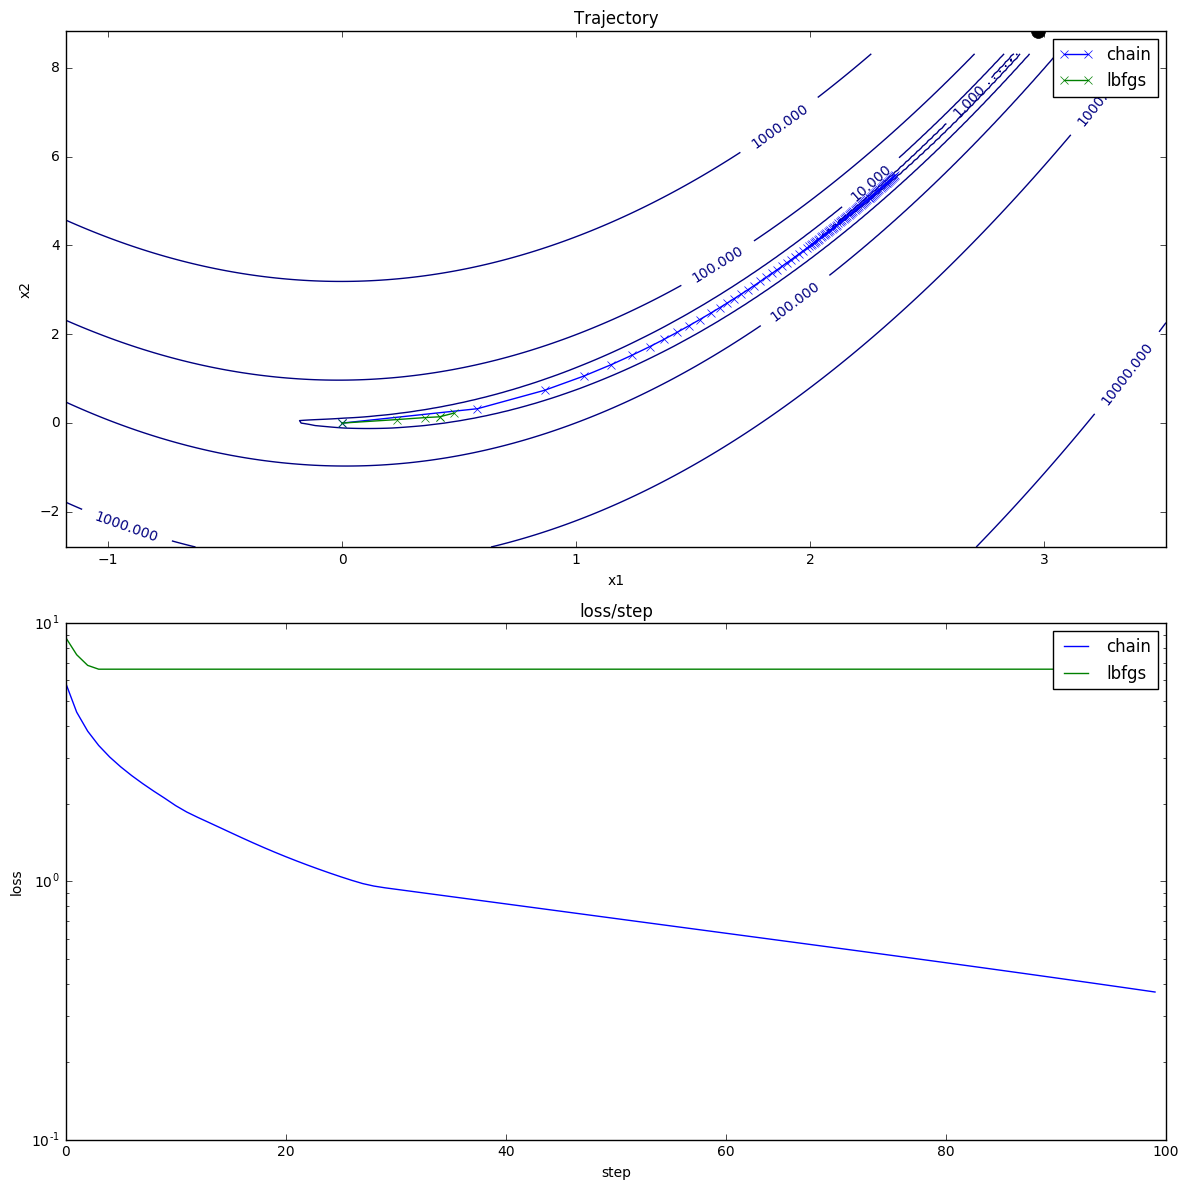

In [38]:
%matplotlib inline
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

(-0.27867737741800536, 0.0776610806845774)


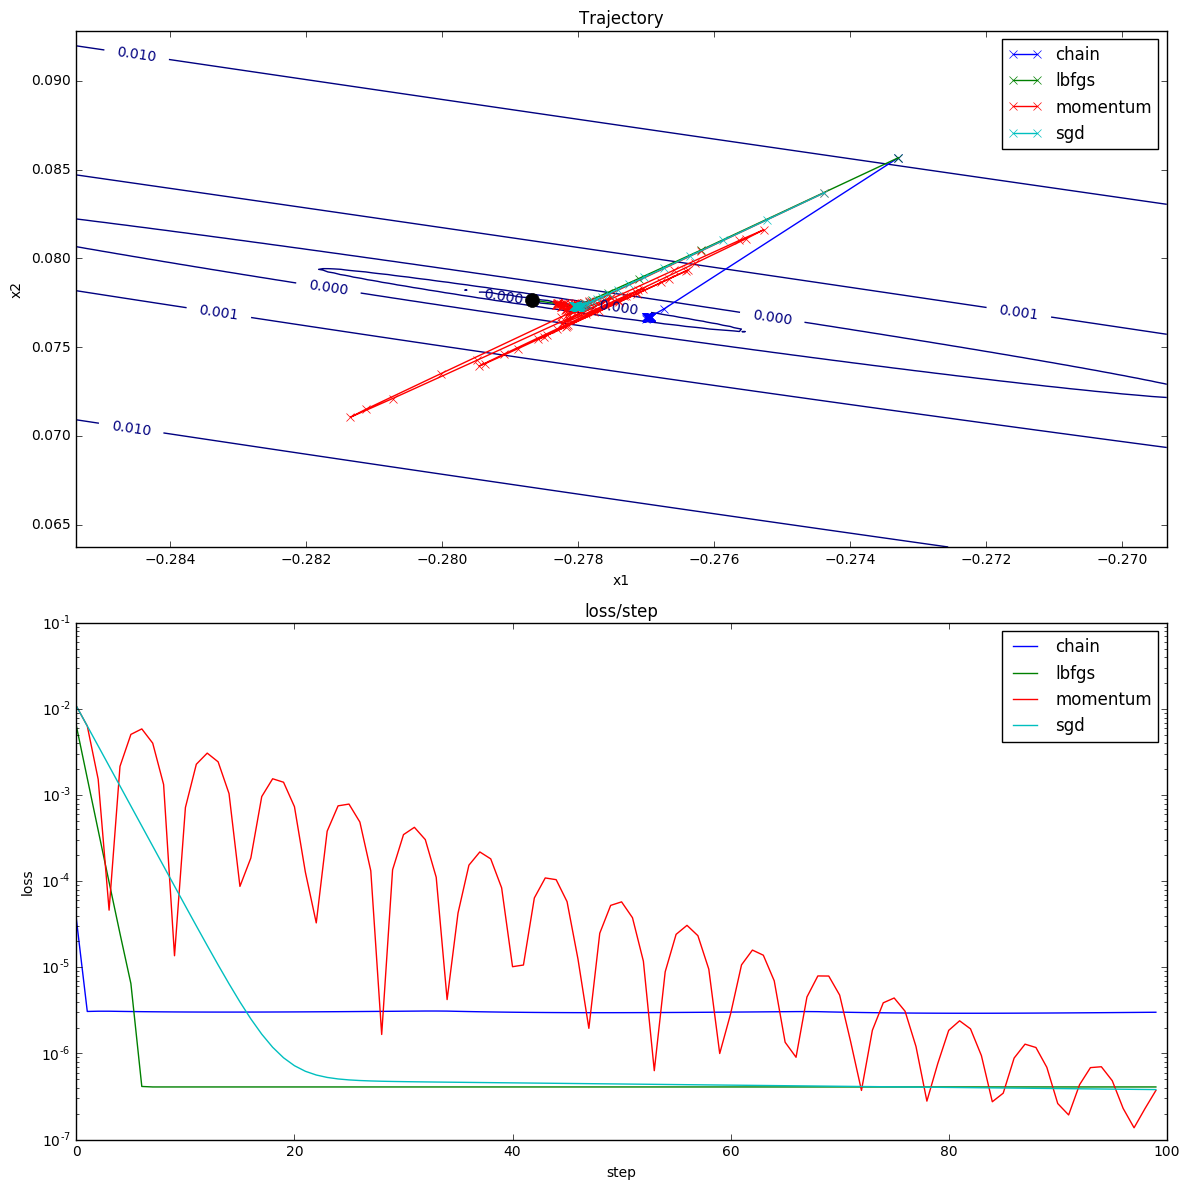

In [39]:
%matplotlib inline
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, non_lstm_optimizers)

(0.060366797910189174, 0.00364415028992962)


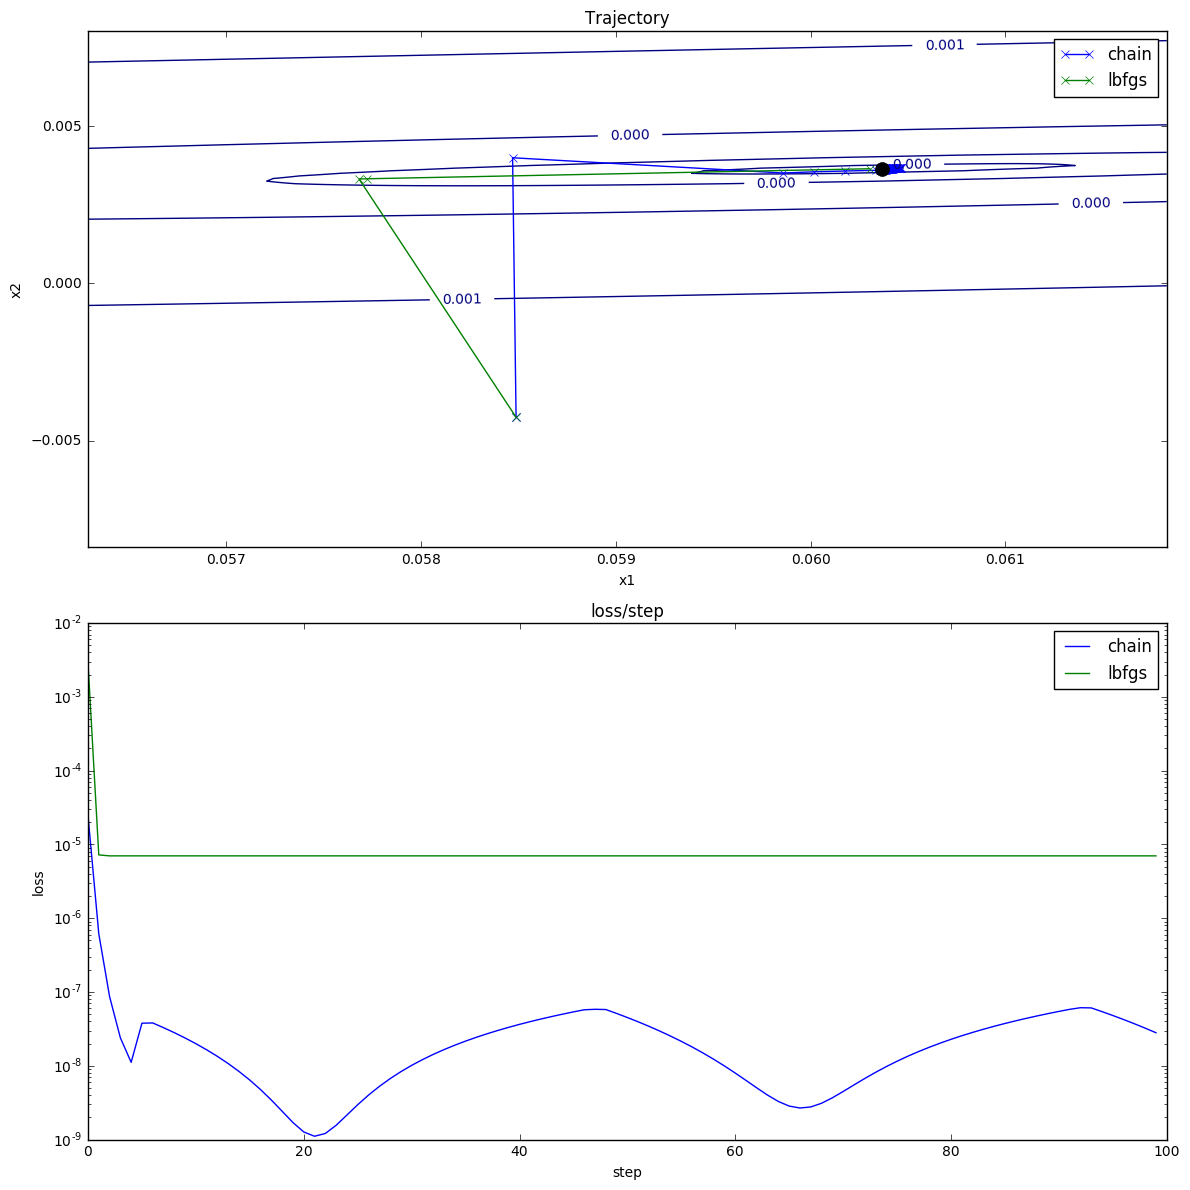

In [40]:
%matplotlib inline
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

In [43]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results_2 = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results_2.append(histories)

Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs


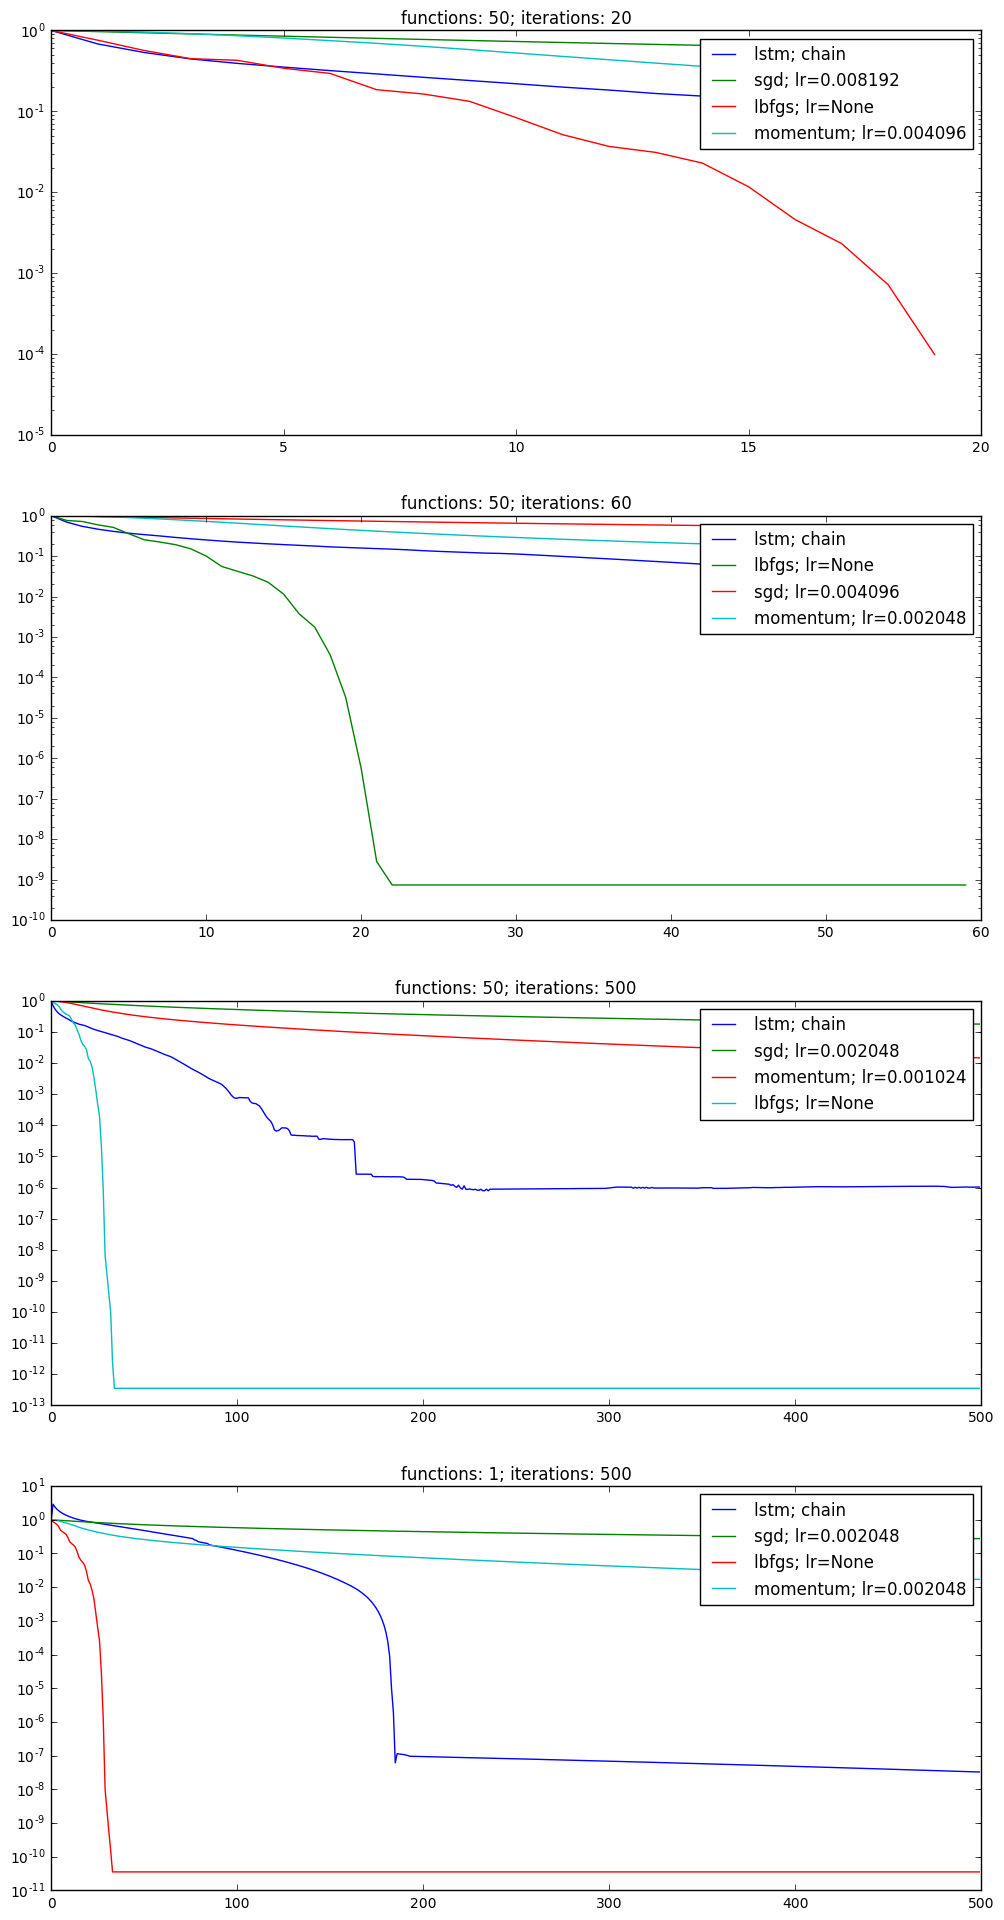

In [44]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results_2), figsize=(12, 6 * len(tests_results_2)))

if len(tests_results_2) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results_2):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()